<a href="https://colab.research.google.com/github/IrinaBoyarchukova/A_B_test/blob/main/%D0%A3%D1%80%D0%BE%D0%BA_8__%22A_B_Python_new_ipynb%22%22%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A/B tests с Python




<a id="Libraries"></a>
##  Загрузка библиотек 

In [141]:
from scipy.stats import ttest_1samp
import numpy as np
from scipy.stats import stats
import warnings
warnings.filterwarnings('ignore')
warnings.warn('DelftStack')
warnings.warn('Do not show this message')
from statsmodels.stats.power import TTestIndPower

In [142]:
import matplotlib.pyplot as plt
import seaborn as sns             # визуализация
import pandas as pd               # табличные данные



<a id="H0"></a>

##Тестирование гипотез

###Гипотеза для коэффициента корелляции
Коэффициент корреляции в 2-х группах отличается ли статистически значимо от 0

In [125]:
from scipy.stats import pearsonr

data1 = [0.873, 2.817, 0.121, -0.945, -0.055, -1.436, 0.360, -1.478, -1.637, -1.869]

data2 = [0.353, 3.517, 0.125, -7.545, -0.555, -1.536, 3.350, -1.578, -3.537, -1.579]

stat, p = pearsonr(data1, data2)

print('stat=%.3f, p=%.3f' % (stat, p))
if p < 0.05:
    print('Groups are different (reject H0)')
else:
    print('Groups are similar (fail to reject H0)')

stat=0.688, p=0.028
Groups are different (reject H0)


Коэффицент корреляции 0.68 Довольно серьезная, статистически значимая  положительная связь. p-value > alpha => Отвергаем нулевую гипотезу, что коэффициент корреляции = 0.

#Поработаем с датасетом c покупками

Метрики
ARPU или Average Revenue Per User - является производным показателем, рассчитывается как средневзвешенное за период агрегации значение Платежи LT/Регистрации. Отображает прибыль, полученную нами с 1 регистрации пользователя, также известен.

ARPPU или Average Revenue Per Paying User - средний платеж платящего пользователя. Рассчитывается как средневзвешенное значение (Платежи LT/Впервые заплативших LT) за период агрегации. Показывает, сколько, в среднем, платит пользователь, ставший платящим, и, зарегистрированный в период агрегации, за всю жизнь.



#Подготовка данных

In [126]:
#Подгружаем данные с гугл диска
# from google.colab import drive
#drive.mount('/content/drive')
#data = pd.read_csv('/content/drive/MyDrive/data/ab_stats.csv')

data = pd.read_csv('ab_stats.csv')
data.head(10)

,revenue,num_purchases,purchase,ab_group,av_site visit
0,0.0,0,0,A,9.040174
1,0.0,0,0,A,4.811628
2,0.0,0,0,A,7.342623
3,0.0,0,0,A,7.744581
4,0.0,0,0,A,10.511814
5,0.0,0,0,A,9.578727
6,0.0,0,0,A,6.162601
7,0.0,0,0,A,11.909452
8,0.0,0,0,A,6.540910
9,0.0,0,0,A,7.990794


In [127]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23652 entries, 0 to 23651
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   revenue        23652 non-null  float64
 1   num_purchases  23652 non-null  int64  
 2   purchase       23652 non-null  int64  
 3   ab_group       23652 non-null  object 
 4   av_site visit  23652 non-null  float64
dtypes: float64(2), int64(2), object(1)
memory usage: 924.0+ KB


In [ ]:
data.shape

(23652, 5)

In [128]:
data.describe()

,revenue,num_purchases,purchase,av_site visit
count,23652.000000,23652.000000,23652.000000,23652.000000
mean,0.324689,0.043590,0.020717,7.013112
std,9.557730,1.079403,0.142438,3.154584
min,0.000000,0.000000,0.000000,-12.073486
25%,0.000000,0.000000,0.000000,5.173787
50%,0.000000,0.000000,0.000000,7.007936
75%,0.000000,0.000000,0.000000,8.864119
max,1303.609284,152.000000,1.000000,22.446822


In [129]:
data.isna().sum()

revenue          0
num_purchases    0
purchase         0
ab_group         0
av_site visit    0
dtype: int64

In [130]:
data.ab_group.value_counts()

A    11835
B    11817
Name: ab_group, dtype: int64

In [131]:
data[data['revenue']>0]

,revenue,num_purchases,purchase,ab_group,av_site visit
45,1.885595,1,1,A,7.654627
54,1.002159,1,1,A,6.392489
82,2.990000,1,1,A,8.596604
104,49.990000,1,1,A,8.885633
110,22.093757,4,1,A,8.708759
...,...,...,...,...,...
23426,2.489611,1,1,B,9.015714
23493,74.950000,5,1,B,5.881950
23495,3.667866,1,1,B,7.450014
23584,19.990000,1,1,B,9.813696


Посмотрим на группы отдельно

In [132]:
data[data['ab_group']=='A'].describe()

,revenue,num_purchases,purchase,av_site visit
count,11835.000000,11835.000000,11835.000000,11835.000000
mean,0.404462,0.050697,0.021631,6.974724
std,13.133218,1.467511,0.145481,2.023533
min,0.000000,0.000000,0.000000,-12.073486
25%,0.000000,0.000000,0.000000,5.656155
50%,0.000000,0.000000,0.000000,6.982329
75%,0.000000,0.000000,0.000000,8.345572
max,1303.609284,152.000000,1.000000,17.728836


In [133]:
data[data['ab_group']=='B'].describe()

,revenue,num_purchases,purchase,av_site visit
count,11817.000000,11817.000000,11817.000000,11817.000000
mean,0.244794,0.036473,0.019802,7.051559
std,3.176534,0.418480,0.139325,3.976799
min,0.000000,0.000000,0.000000,-8.286822
25%,0.000000,0.000000,0.000000,4.380984
50%,0.000000,0.000000,0.000000,7.060873
75%,0.000000,0.000000,0.000000,9.768648
max,113.830000,25.000000,1.000000,22.446822


Пока мы еще ничего не посчитали, но уже можно заметить, что максимальный чек в первой группе сильно больше, чем в группе B. Все мы знаем, что среднее очень неустойчиво к выбросам, так что нам необходимо будет это учесть.

#Проверка на нормальность распределения и применение статистических критериев

##Метрика визиты на юзера

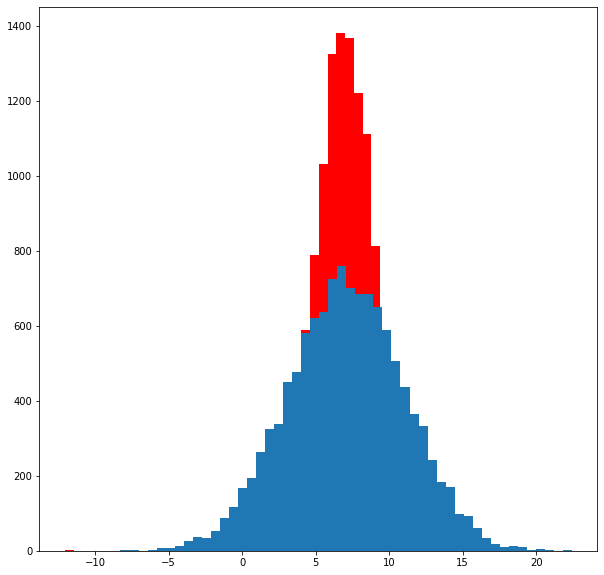

In [139]:
plt.figure(figsize=(10, 10))
control_visit_all = data['av_site visit'][data['ab_group'] == 'A']
test_visit_all =data['av_site visit'][data['ab_group'] == 'B']


plt.hist(control_visit_all, color='r', bins=50)
plt.hist(test_visit_all,  bins=50)


plt.show()

In [143]:
# T-test в качестве статистического критерия.

stats.ttest_ind(control_visit_all, test_visit_all, equal_var = False)   # Указываем, что дисперсии не равны

Ttest_indResult(statistic=-1.872183970103851, pvalue=0.06119777801292236)

##Метрика доля юзеров с покупкой

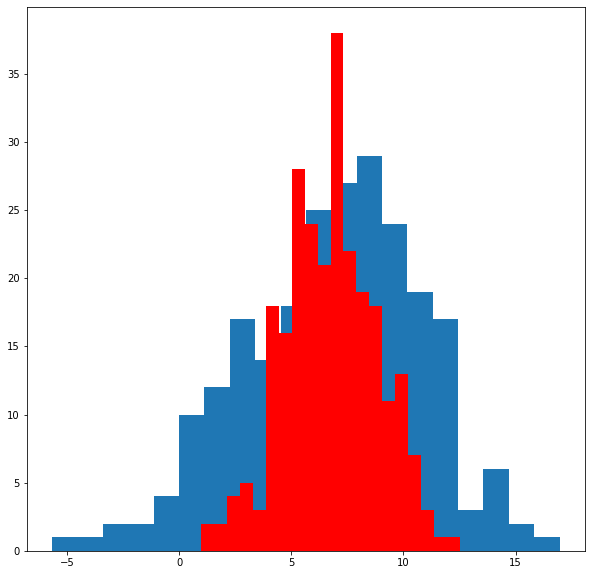

In [ ]:
plt.figure(figsize=(10, 10))
control_visit = data['av_site visit'][(data['ab_group'] == 'A')&(data['purchase'] == 1)]
test_visit =data['av_site visit'][(data['ab_group'] == 'B')&(data['purchase'] == 1)]
plt.hist(test_visit,  bins=20)
plt.hist(control_visit, color='r', bins=20)

plt.show()

In [ ]:
data['purchase'].value_counts()

0    23162
1      490
Name: purchase, dtype: int64

In [ ]:
k1 = data[data['ab_group']=='A']['purchase'].sum()
k2 = data[data['ab_group']=='B']['purchase'].sum()

In [ ]:
n1 = data[data['ab_group']=='A'].shape[0]
n2 = data[data['ab_group']=='B'].shape[0]

In [ ]:
from statsmodels.stats import proportion

z_score, z_pvalue = proportion.proportions_ztest(np.array([k1, k2]), 
                                                   np.array([n1, n2]))
print('Results are ','z_score =%.3f, pvalue = %.3f'%(z_score, z_pvalue))

Results are  z_score =0.987, pvalue = 0.323


In [ ]:
if abs(z_pvalue) < 0.05:
    print("We may reject the null hypothesis!")
else:
    print("We have failed to reject the null hypothesis")

We have failed to reject the null hypothesis


Непараметрический Хи-квадрат

In [ ]:
chisq, pvalue, table = proportion.proportions_chisquare(np.array([k1, k2]), 
                                                   np.array([n1, n2]))

print('Results are ','chisq =%.3f, pvalue = %.3f'%(chisq, pvalue))

Results are  chisq =0.975, pvalue = 0.323


In [ ]:
if abs(pvalue) < 0.05:
    print("We may reject the null hypothesis!")
else:
    print("We have failed to reject the null hypothesis")

We have failed to reject the null hypothesis


#Метрика arpu


 Непараметрический критерий  Манн-Уитни

In [11]:
data.groupby('ab_group')['revenue'].describe()

,count,mean,std,min,25%,50%,75%,max
ab_group,,,,,,,,
A,11835.0,0.404462,13.133218,0.0,0.0,0.0,0.0,1303.609284
B,11817.0,0.244794,3.176534,0.0,0.0,0.0,0.0,113.830000


In [12]:
from scipy.stats import mannwhitneyu
mw_stats = mannwhitneyu(x=data[(data['ab_group'] == 'A')]['revenue'].values,
                                                  y=data[(data['ab_group'] == 'B')]['revenue'].values)
mw_stats

MannwhitneyuResult(statistic=70054756.0, pvalue=0.3243889561742552)

**Критерий Манна Уитни нам не позволяет принять альтернативную гипотезу о разнице ARPU**

**Может быть среднее количество пользователя отличается?**

In [13]:
mw_stats = mannwhitneyu(x=data[(data['ab_group'] == 'A')]['num_purchases'].values,
                                                  y=data[(data['ab_group'] == 'B')]['num_purchases'].values)
mw_stats

MannwhitneyuResult(statistic=70054599.0, pvalue=0.3249718497892071)

Давайте еще посмотрим на пользователях среди платящих

In [14]:
mw_stats = mannwhitneyu(x=data[(data['ab_group'] == 'A')&(data['purchase'] == 1)]['revenue'].values,
                                                  y=data[(data['ab_group'] == 'B')&(data['purchase'] == 1)]['revenue'].values)
mw_stats

MannwhitneyuResult(statistic=29729.5, pvalue=0.8871956616344514)

Выкатывать из тестовой группы нецелесообразно, поскольку поскольку результаты теста по основным метрикам не различаются и основания отвергнуть нулевую гипотезу у нас нет. Лополнительно смотрим мощность теста

##Рассмотрим кейс с рекламной выручкой

In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google_drive_downloader import GoogleDriveDownloader as gdd

gdd.download_file_from_google_drive(file_id='1IGMgJP_XqQwA6h_w1KYG7TQJhS15h4c4',
                                    dest_path='./test.xlsx');

In [61]:
df = pd.read_excel('test.xlsx')

In [62]:
df.head(10)

,USER_ID,VARIANT_NAME,REVENUE
0,737,variant,0.0
1,2423,control,0.0
2,9411,control,0.0
3,7311,control,0.0
4,6174,variant,0.0
5,2380,variant,0.0
6,2849,control,0.0
7,9168,control,0.0
8,6205,variant,0.0
9,7548,control,0.0


In [63]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   USER_ID       10000 non-null  int64  
 1   VARIANT_NAME  10000 non-null  object 
 2   REVENUE       10000 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 234.5+ KB


In [64]:
df.describe()

,USER_ID,REVENUE
count,10000.000000,10000.000000
mean,4981.080200,0.099447
std,2890.590115,2.318529
min,2.000000,0.000000
25%,2468.750000,0.000000
50%,4962.000000,0.000000
75%,7511.500000,0.000000
max,10000.000000,196.010000


In [65]:
df.isna().sum()

USER_ID         0
VARIANT_NAME    0
REVENUE         0
dtype: int64

In [66]:
df.VARIANT_NAME.value_counts()

variant    5016
control    4984
Name: VARIANT_NAME, dtype: int64

In [67]:
#Избавимся от некорретных строк. Посчитаем, сколько типов встречается у каждого пользователя.

v = df.\
    groupby('USER_ID', as_index=False).\
    agg({'VARIANT_NAME': pd.Series.nunique})

In [68]:
v.head(10)

,USER_ID,VARIANT_NAME
0,2,1
1,3,2
2,4,1
3,5,1
4,6,1
5,9,1
6,10,2
7,11,1
8,12,1
9,13,1


In [83]:
more_than_one_types = v.query('VARIANT_NAME > 1')

In [106]:
df_new = df[~df.USER_ID.isin(more_than_one_types.USER_ID)].sort_values('USER_ID')

df_new

,USER_ID,VARIANT_NAME,REVENUE
3479,2,control,0.0
7076,2,control,0.0
2406,2,control,0.0
9077,4,variant,0.0
9155,5,variant,0.0
...,...,...,...
3260,9992,control,0.0
9290,9993,control,0.0
2749,9995,variant,0.0
5673,9995,variant,0.0


In [85]:
df_new.shape

(6070, 3)

In [107]:
df.shape

(10000, 3)

In [108]:
control = df_new.query('VARIANT_NAME == "control"')

test = df_new.query('VARIANT_NAME == "variant"')

In [92]:
len(control)

3026

In [109]:
len(test)

3044

In [94]:
from scipy.stats import shapiro

In [110]:
alpha = 0.05

st = shapiro(df.REVENUE)
print('Distribution is {}normal\n'.format( {True:'not ',
False:''}[st[1] < alpha]));

Distribution is not normal



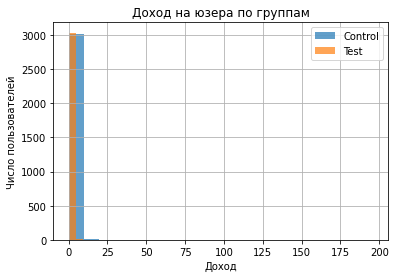

In [111]:
control.REVENUE.hist(bins = 20, alpha =0.7, label='Control')
test.REVENUE.hist(bins = 5, alpha =0.7, label='Test')
plt.title('Доход на юзера по группам')
plt.xlabel('Доход')
plt.ylabel('Число пользователей')
plt.legend();

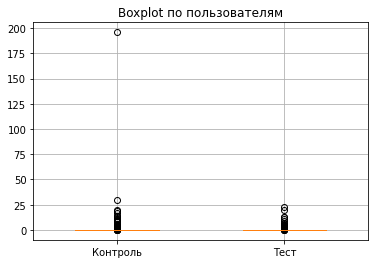

In [112]:
plt.boxplot([control.REVENUE,test.REVENUE],
            labels=['Контроль','Тест'],
            widths=0.5
           )
plt.title('Boxplot по пользователям',  loc='center')
plt.grid(axis  ='both')

In [144]:
# ttest лучше применять на больших выборках. Когда сотни тысяч и более наблюдений, речь про СРЕДНИЕ ЗНАЧЕНИЯ независимых
# случайно распределенных величин, можно ссылаться на ЦПТ и сделать T-test т.к.средние значения по ЦПТ - нормально распределены.
# Здесь распределение не нормальное. И выбросы могут сильно влиять на результат!
# Сделали просто, чтобы посмотреть как отработает.

stats.ttest_ind(control.REVENUE.values, test.REVENUE.values, equal_var = False)

Ttest_indResult(statistic=1.403762252371675, pvalue=0.1604844017690842)

##Расчет мощности
---
Вероятность зафиксировать результат, когда он действительно есть.
Тесты показали, что разницы между группами нет => проверяем, вдруг просто тест не достаточно мощный по такому объему выборки, при такой дисперсии, с такими вводными, чтобы зафиксировать результат по такой-то метрике. 



d Коэна - Effect_size - стандартизированная средняя разница

d = (M1 – M2) / S_pooled






## S_pooled =
# Standart Deviation Pooled

## $\text{S_pooled} = \sqrt{\frac{(S_1^2 + S_2^2)}{2}}$

pooled - объединенный.

S_pooled нужна для расчета effect_size

  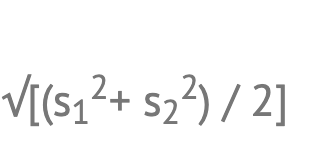

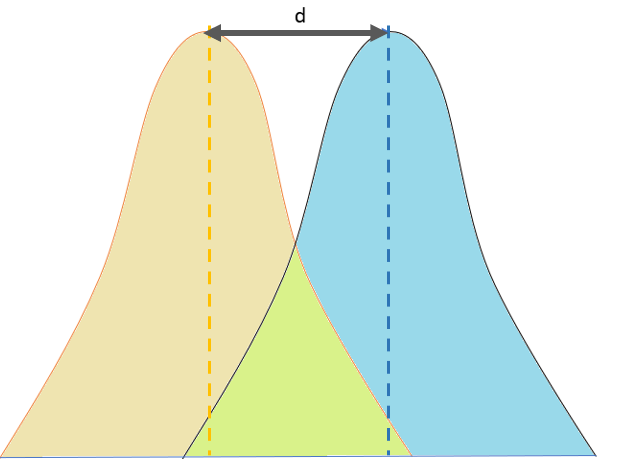

In [113]:
C_mean = control.REVENUE.values.mean()

T_mean = test.REVENUE.values.mean()


C_std = control.REVENUE.values.std()

T_std = test.REVENUE.values.std()

In [ ]:
print(len(control.REVENUE.values), len(test.REVENUE.values))

3026 3044


In [114]:
n =  len(control.REVENUE.values)

In [115]:
##S = np.sqrt((sd_t**2 / n_t) + (sd_c**2 / n_c))

S = np.sqrt((T_std**2 + C_std **2)/ 2)

In [116]:
ef =float((T_mean-C_mean)/ S) 

In [123]:
# parameters for power analysis

alpha = 0.05

# perform power analysis
analysis = TTestIndPower()
result = analysis.solve_power(ef, power=None, nobs1=n, ratio=1.0, alpha=alpha)
# Ищем мощность => power=None.

result

0.2893670730459212

Получили, что мощность очень низкая, на уровне 29%. Нельзя быть уверенным в 

---

результате теста.

---



=> Тест лучше перезапустить, поставить его корректно, увеличить выборки, расчитать и выборки и сколько дней держать тест.